# Exploratory data analysis phase
----------


### Questions to answer: 
- is there a relationship between sales & gender, age, category?
- does seasonality cause changes in sales?

### Looking into data

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pygam import LinearGAM
import numpy as np
import statsmodels.api as sm

In [2]:
# Deserialize the DataFrame
df = pd.read_pickle("data.pkl")
df.head()

,transaction_id,sales,date,category,units,gender,age
0,100S5713W16321BY,63,2023-08-18,Clothing,3,Female,20
1,100U7280H90017IB,126,2023-09-21,Clothing,7,Male,20
2,100X9564D67104YE,192,2023-10-02,Electronics,4,Male,51
3,100Y9513C90580VX,104,2023-04-09,Clothing,4,Female,37
4,102I4872M87046QG,72,2023-08-05,Clothing,4,Male,59


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  982 non-null    object        
 1   sales           982 non-null    int64         
 2   date            982 non-null    datetime64[ns]
 3   category        982 non-null    category      
 4   units           982 non-null    int32         
 5   gender          982 non-null    category      
 6   age             982 non-null    int64         
dtypes: category(2), datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 36.6+ KB


In [4]:
df.describe()

,sales,date,units,age
count,982.000000,982,982.000000,982.000000
mean,200.336049,2023-07-09 17:05:00.610998016,4.681263,41.401222
min,3.000000,2023-01-02 00:00:00,1.000000,18.000000
25%,40.000000,2023-04-24 12:00:00,2.000000,29.250000
50%,90.000000,2023-07-19 00:00:00,4.000000,42.000000
75%,158.250000,2023-10-04 00:00:00,6.000000,53.000000
max,5529.000000,2024-01-01 00:00:00,21.000000,64.000000
std,523.742816,NaN,3.154408,13.707514


In [5]:
df.nunique()

transaction_id    982
sales             241
date              219
category            3
units              20
gender              2
age                47
dtype: int64

### Adding new variables

In [6]:
### Adding month
df['month'] = df['date'].dt.month

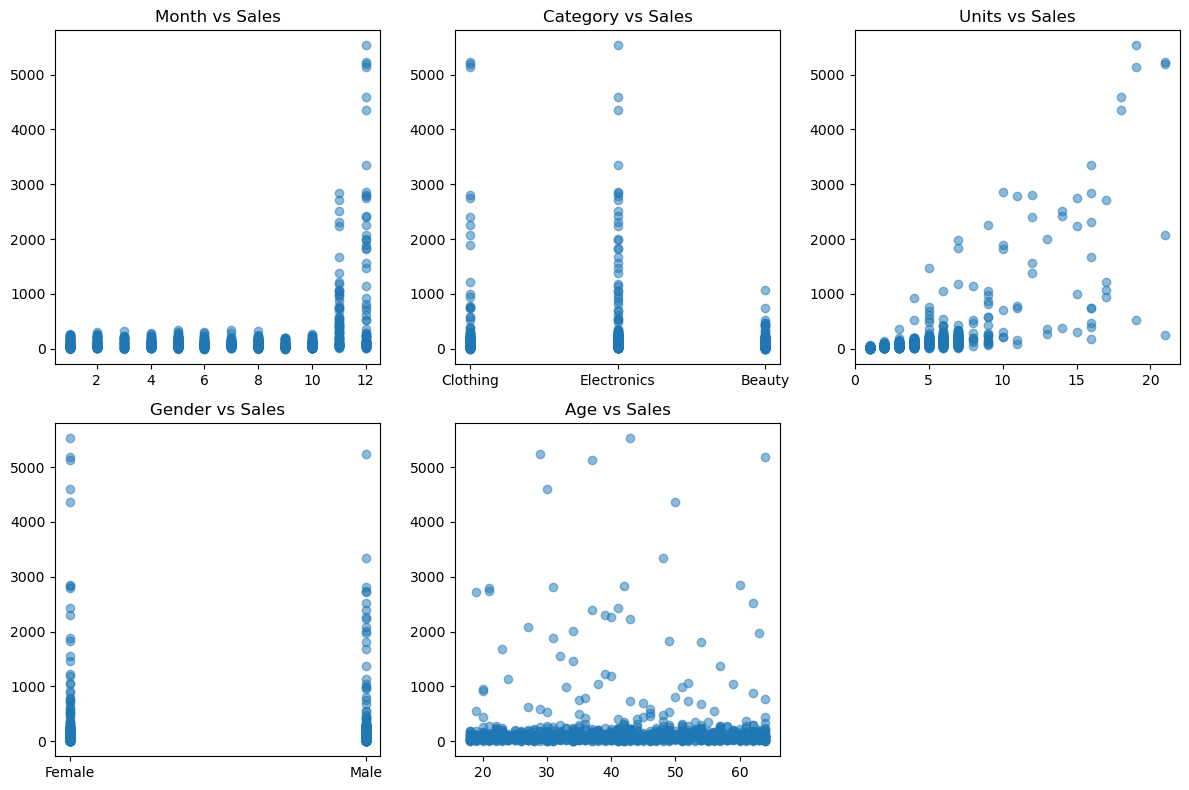

In [7]:
# checking out scatter plots for each variable against sales

explanatories = ['month', 'category', 'units', 'gender', 'age']

plt.figure(figsize=(12, 8))

# simple for loop for printing multiple plots
for i, variable in enumerate(explanatories, start=1):
    plt.subplot(2, 3, i)
    plt.scatter(df[variable], df['sales'], alpha=0.5)
    plt.title(f'{variable.capitalize()} vs Sales')

plt.tight_layout()
plt.show()


#### Initially it seems that; 
- November and December are high points for sales
- Electronics cause high variability in sales, beauty appears to account for lowest amount of sales.
- Units and sales has a positive non-linear relationship, potentially quadratic, but there is much scatter so further investigation needed. 
- gender and age seem randomly distributed, no indication of relationship to sales 

<Figure size 640x480 with 0 Axes>

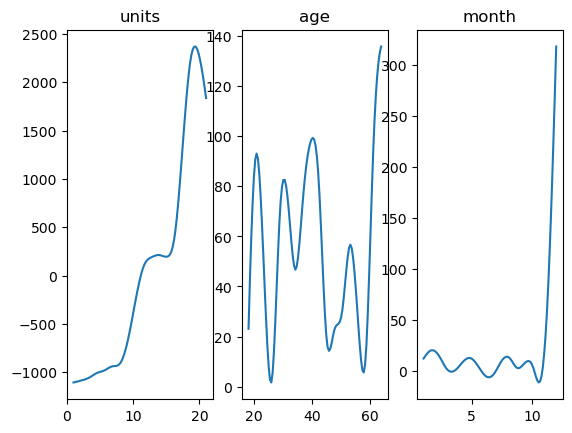

In [8]:
# using GAM smoothing to understand explanatory variables

# explanatory 
X = df[['units', 'age', 'month']]

# dependent 
y = df['sales'] 
gam = LinearGAM().fit(X, y)

# Plot the GAM fit
plt.figure()
fig, axs = plt.subplots(1, len(X.columns))
titles = X.columns
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.set_title(titles[i])
plt.show()


#### Making age categorical
The glm pattern indicated perhaps age could be better in groups.

age groups:  
 18-24 (young adults), 25-34 (young professionals), 35-44 (established professionals), 45-54 (middle-aged), 55+ (pre-retirement) (maximum is 65)

In [9]:
# defining groups & labels
bins = [18, 25, 35, 45, 55, float('inf')]
labels = ['18-24', '25-34', '35-44', '45-54', '55+']

# Add new categorical column
df['age_category'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)


c:\Users\Isabel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Isabel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


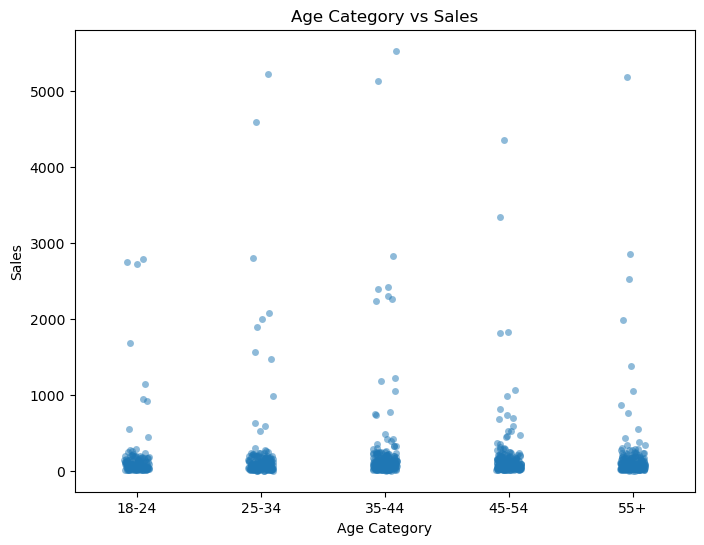

In [10]:
# plot for age_category against sales
plt.figure(figsize=(8, 6))
sns.stripplot(x='age_category', y='sales', data=df, alpha=0.5)
plt.title('Age Category vs Sales')
plt.xlabel('Age Category')
plt.ylabel('Sales')
plt.show()


#### Convert categorical variables into booleans using one-hot encoding

In [11]:
df = pd.get_dummies(df, columns=['category', 'gender', 'age_category', 'month'], drop_first=True)
# drop one category from each categorical variable to act as baselines (avoid multicollinearity) 

print(df.columns)
df.head(2)

Index(['transaction_id', 'sales', 'date', 'units', 'age', 'category_Clothing',
       'category_Electronics', 'gender_Male', 'age_category_25-34',
       'age_category_35-44', 'age_category_45-54', 'age_category_55+',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')


,transaction_id,sales,date,units,age,category_Clothing,category_Electronics,gender_Male,age_category_25-34,age_category_35-44,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,100S5713W16321BY,63,2023-08-18,3,20,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,100U7280H90017IB,126,2023-09-21,7,20,True,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False


### fitting an initial model

In [12]:


def split_data(X, y):
    ''' split into train and test sets for later evaluation '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


def fit_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model


def fit_ols_model(X_train, y_train):
    X_train_int = sm.add_constant(X_train.astype(int))
    ols_model = sm.OLS(y_train, X_train_int)
    results = ols_model.fit()
    return results


def diagnostic_plots(results, X_train):
    '''  check our assumptions using diagnostic plots '''

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    sns.residplot(x=results.fittedvalues, y=results.resid, ax=axes[0, 0])
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs. Fitted Values')

    sm.qqplot(results.resid, line='r', ax=axes[0, 1])
    axes[0, 1].set_title('Normal Q-Q Plot of Residuals')

    sns.scatterplot(x=results.fittedvalues, y=results.resid, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals vs. Fitted Values')

    sns.histplot(results.resid, kde=True, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()


def cooks_plot(results):
    ''' Generates a Cook's distance plot to identify influential points in the data.  '''
    
    infl = results.get_influence()
    cooks_distance = infl.cooks_distance[0]

    plt.figure(figsize=(8, 6))
    plt.stem(np.arange(len(cooks_distance)), cooks_distance, markerfmt=",")
    plt.xlabel('Index')
    plt.ylabel("Cook's Distance")
    plt.title("Cook's Distance Plot")
    plt.show()
    
    
def evaluate_model(model, X_train, X_test, y_train, y_test):
    ''' error rate checking + r^2 '''
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train R^2:", train_r2)
    print("Test R^2:", test_r2)



def create_model(X, y):
    ''' runs the model setting functions '''

    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y)
    model = fit_linear_regression(X_train, y_train)
    evaluate_model(model, X_train, X_test, y_train, y_test)

    # Fit OLS model for statistical summary
    results = fit_ols_model(X_train, y_train)
    print(results.summary())

    # Check residuals
    diagnostic_plots(results, X_train)
    cooks_plot(results)
    return results



In [13]:

''' set features and response variable of model '''

# response
y = df['sales']

# explanatories 
X = df

# drop response variable 
X = X.drop(['sales'], axis=1)
 
# added month instead 
X = X.drop(['date'], axis=1)

# It makes sense to drop months, as the only impactful months on the data were November & December. 
# The rest are explaining the same data. 
X = X.drop(['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10'], axis=1)


X = X.drop(['transaction_id'], axis=1)

# added groups instead 
X = X.drop(['age'], axis=1)


Initial model: linear regression model
sales ~ all  

Train MAE: 215.41946585532352
Test MAE: 192.94086630721378
Train RMSE: 387.9303451713305
Test RMSE: 281.56519548353197
Train R^2: 0.5191842457973919
Test R^2: 0.3258145872505879
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     83.58
Date:                Thu, 09 May 2024   Prob (F-statistic):          5.93e-116
Time:                        07:50:54   Log-Likelihood:                -5793.1
No. Observations:                 785   AIC:                         1.161e+04
Df Residuals:                     774   BIC:                         1.166e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef 

c:\Users\Isabel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


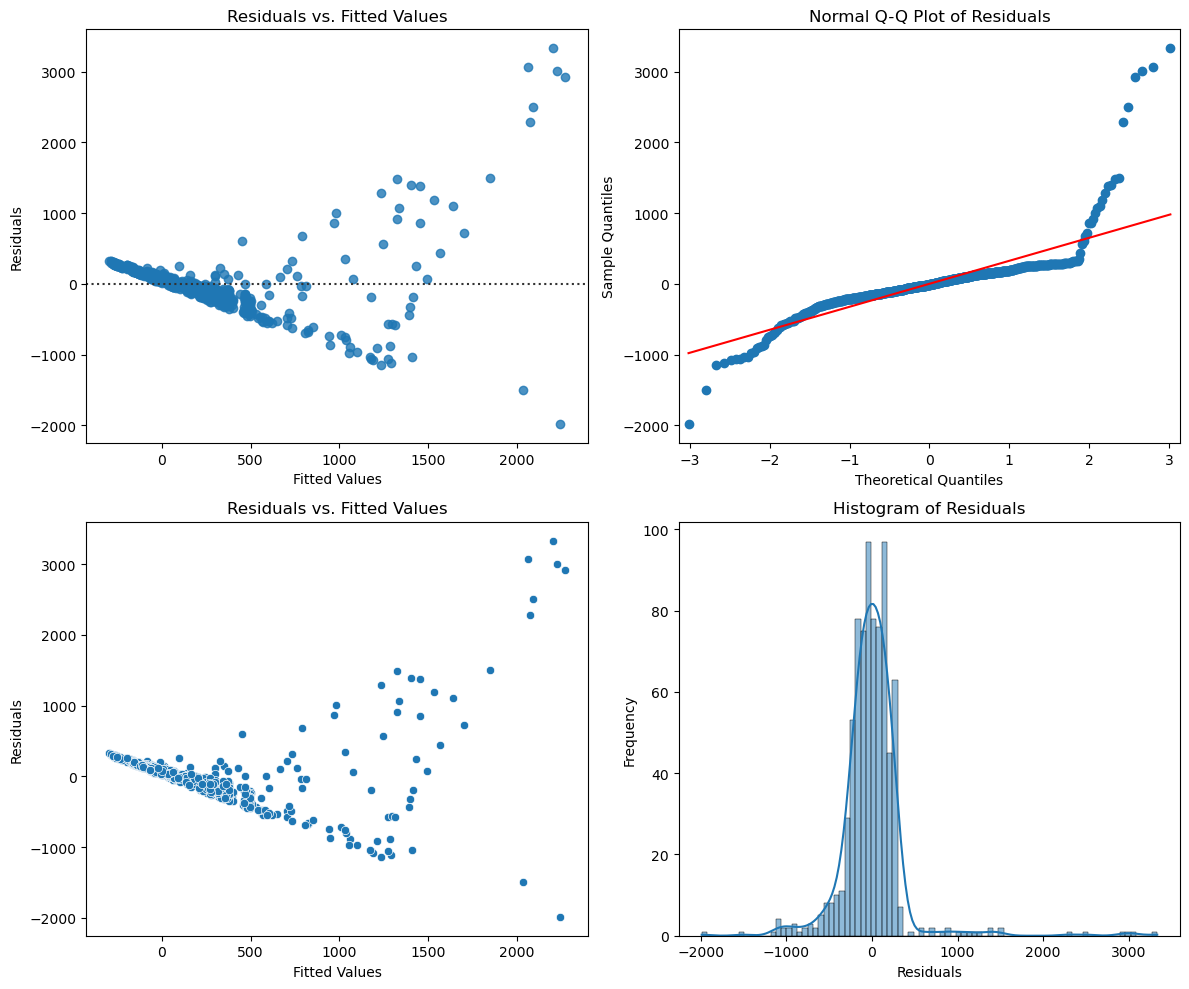

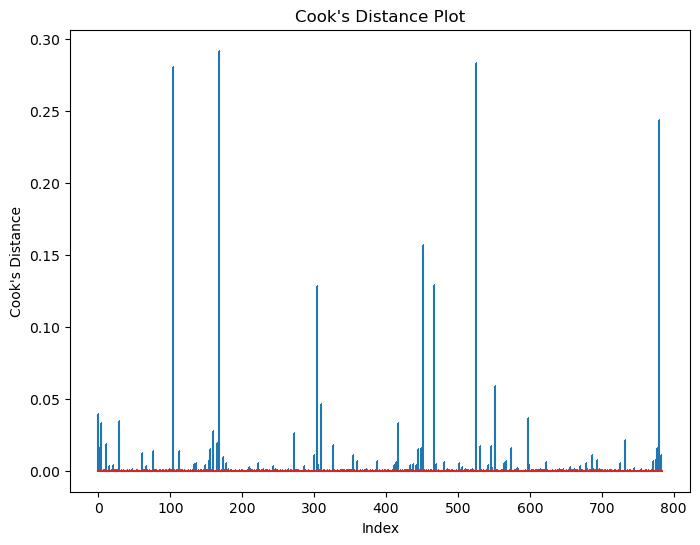

In [14]:
create_model(X, y)


## Log transformation


Due to the large right skew (as shown in the QQ plot & residuals) it makes sense to log transform our model. 

In [15]:
# log transform the response
df['sales_log'] = np.log1p(df['sales'])
y = df['sales_log']

Train MAE: 0.518145045727921
Test MAE: 0.552299415891743
Train RMSE: 0.6561333289458506
Test RMSE: 0.693623203157869
Train R^2: 0.6699020447968194
Test R^2: 0.592141645210448
                            OLS Regression Results                            
Dep. Variable:              sales_log   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     157.1
Date:                Thu, 09 May 2024   Prob (F-statistic):          1.01e-178
Time:                        07:50:55   Log-Likelihood:                -783.07
No. Observations:                 785   AIC:                             1588.
Df Residuals:                     774   BIC:                             1639.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    

c:\Users\Isabel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


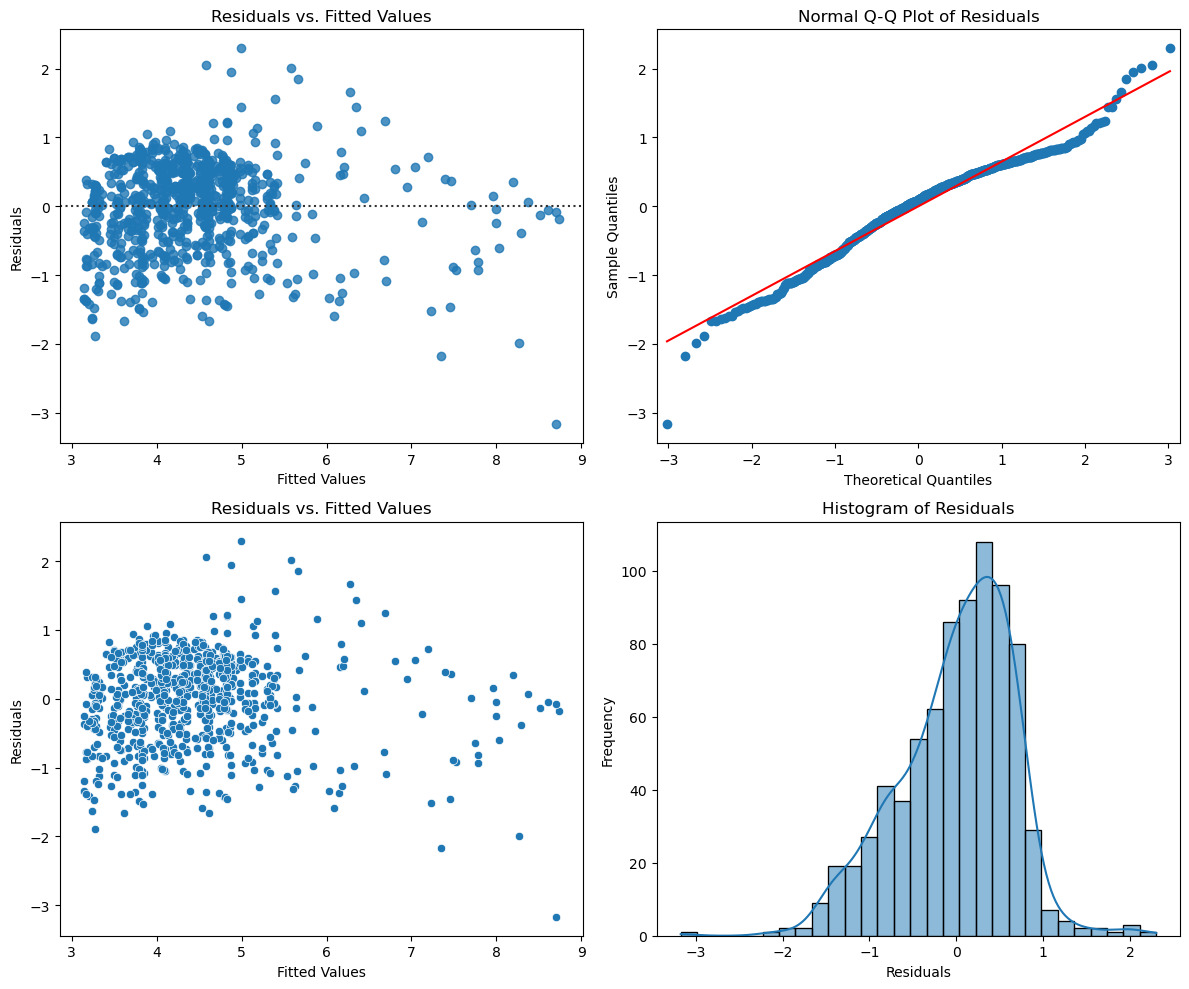

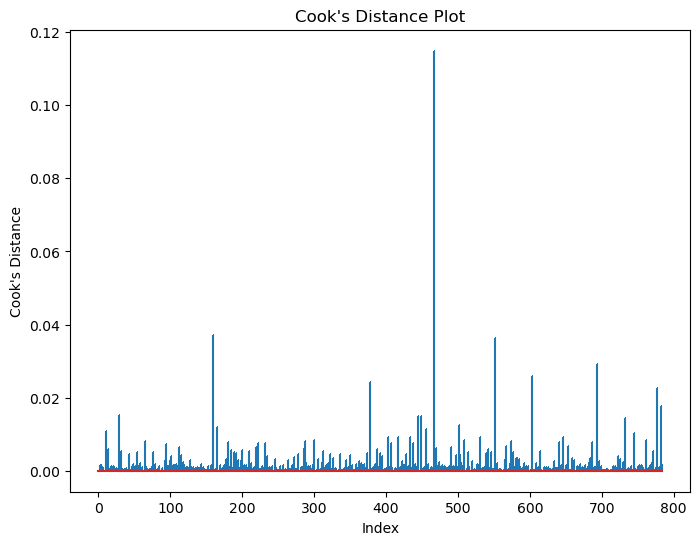

In [16]:
create_model(X, y)

The residuals still indicate some skew in the data. As units had previously appeared potentially quadratic, I added a quadratic term. 

In [17]:
# adding units^2 explanatory 
X['units_squared'] = df['units'] ** 2



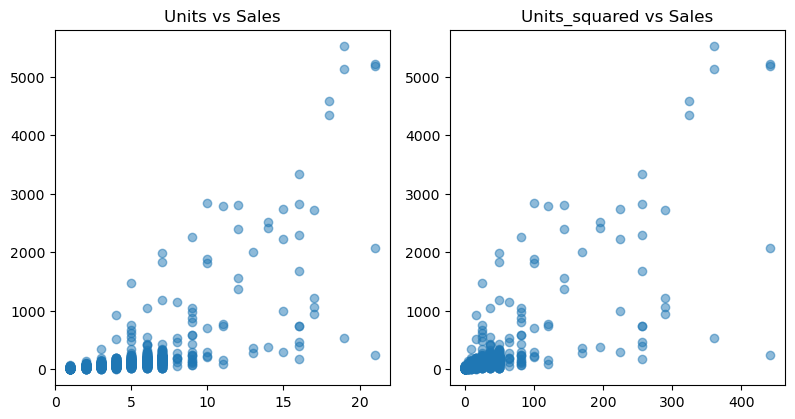

In [18]:
explanatories = ['units', 'units_squared']

plt.figure(figsize=(12, 8))

for i, variable in enumerate(explanatories, start=1):
    plt.subplot(2, 3, i)
    plt.scatter(X[variable], df['sales'], alpha=0.5)
    plt.title(f'{variable.capitalize()} vs Sales')

plt.tight_layout()
plt.show()


Train MAE: 0.5003735139702519
Test MAE: 0.5306808490584078
Train RMSE: 0.6271092376108236
Test RMSE: 0.6668534939320458
Train R^2: 0.6984599288413635
Test R^2: 0.6230159294958424
                            OLS Regression Results                            
Dep. Variable:              sales_log   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     162.8
Date:                Thu, 09 May 2024   Prob (F-statistic):          1.01e-192
Time:                        07:50:57   Log-Likelihood:                -747.56
No. Observations:                 785   AIC:                             1519.
Df Residuals:                     773   BIC:                             1575.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef

c:\Users\Isabel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


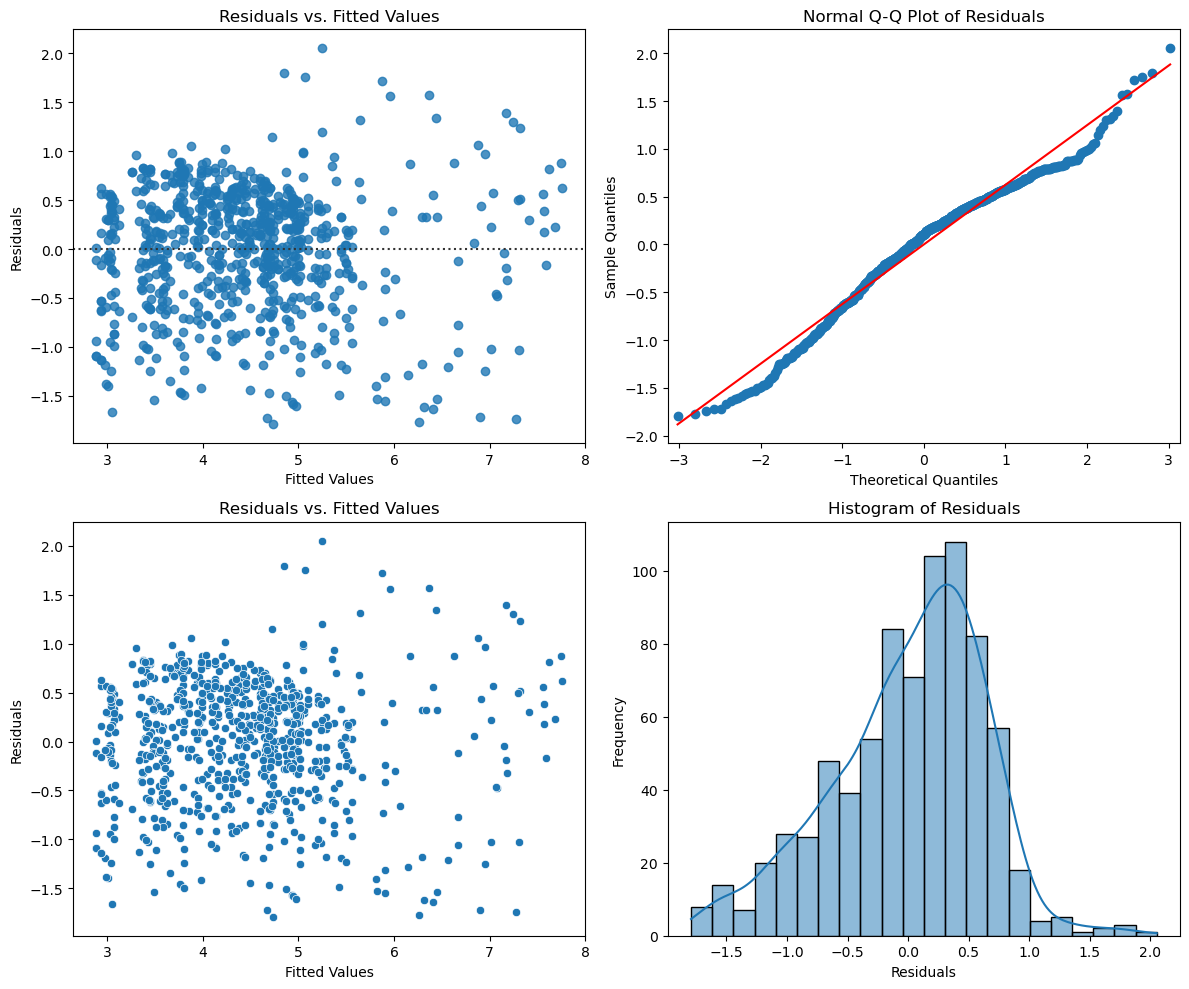

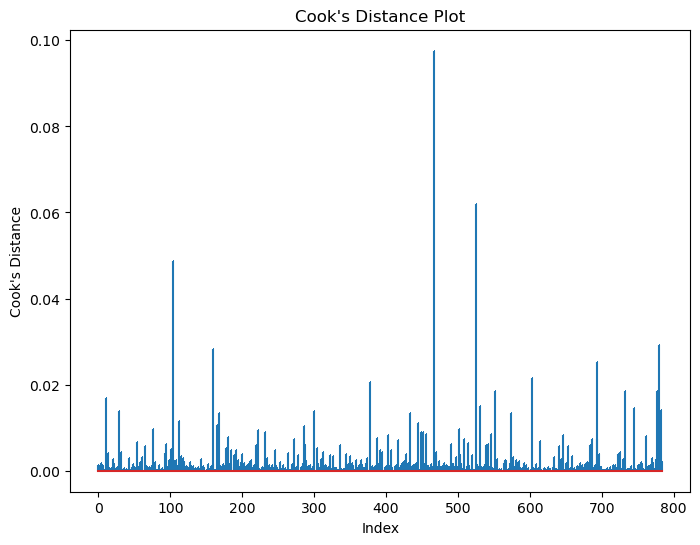

In [19]:
create_model(X, y)

- residuals are looking slightly more normalised.

# Simplifying the model 

There are some explanatory variables with low statistical significance (inferenced from p-values). 
Dropping variables with highest p-value for all p-values > 0.05 one by one


In [20]:

X = X.drop(['age_category_45-54'], axis=1)
X = X.drop(['age_category_55+'], axis=1)
X = X.drop(['category_Clothing'], axis=1)
X = X.drop(['age_category_35-44'], axis=1)
X = X.drop(['gender_Male'], axis=1)


Train MAE: 0.5007494441012976
Test MAE: 0.52871017279796
Train RMSE: 0.6281853106038594
Test RMSE: 0.664597865888548
Train R^2: 0.697424200140569
Test R^2: 0.6255619091483453
                            OLS Regression Results                            
Dep. Variable:              sales_log   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     298.9
Date:                Thu, 09 May 2024   Prob (F-statistic):          4.12e-198
Time:                        07:51:00   Log-Likelihood:                -748.90
No. Observations:                 785   AIC:                             1512.
Df Residuals:                     778   BIC:                             1544.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    

c:\Users\Isabel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


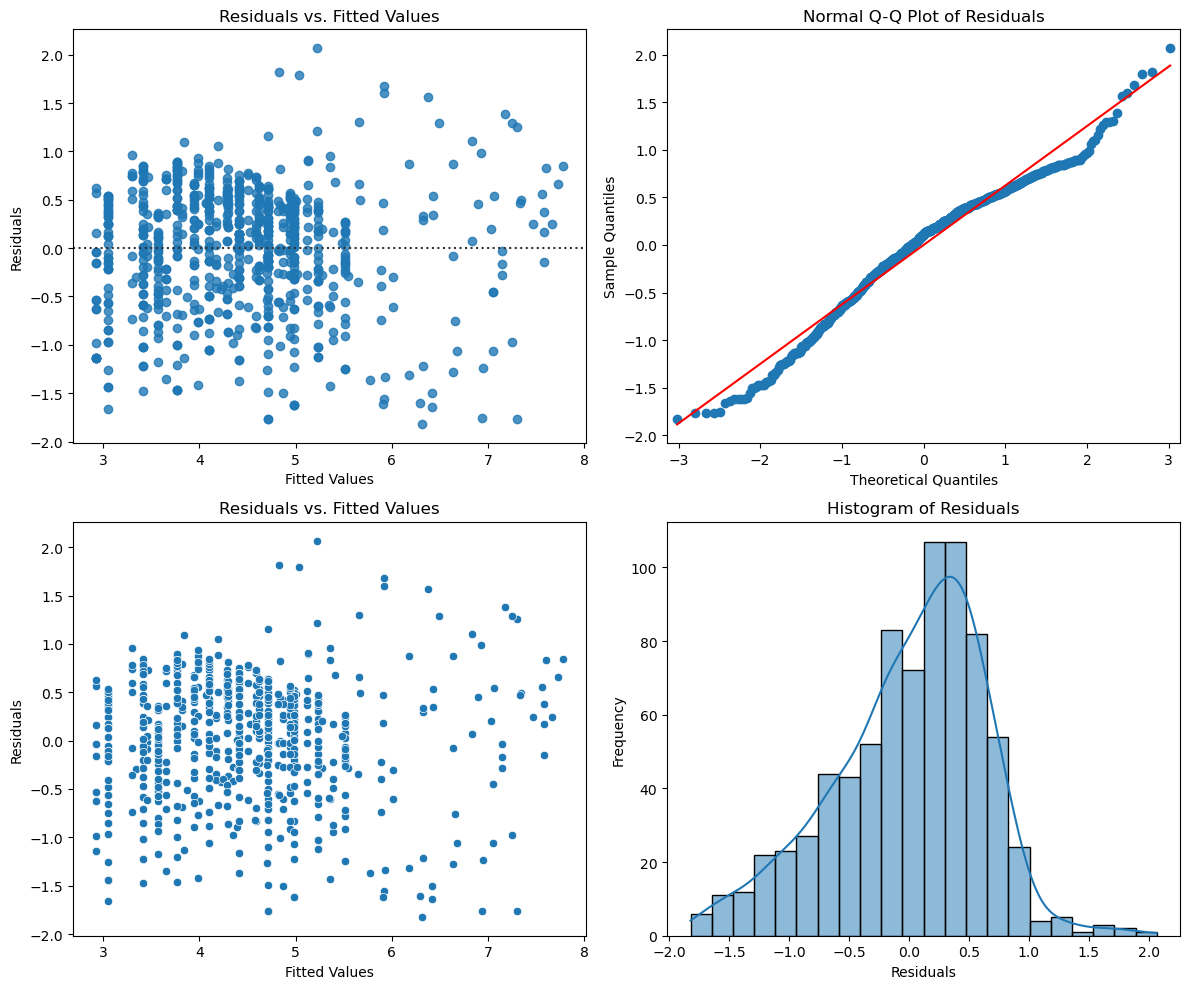

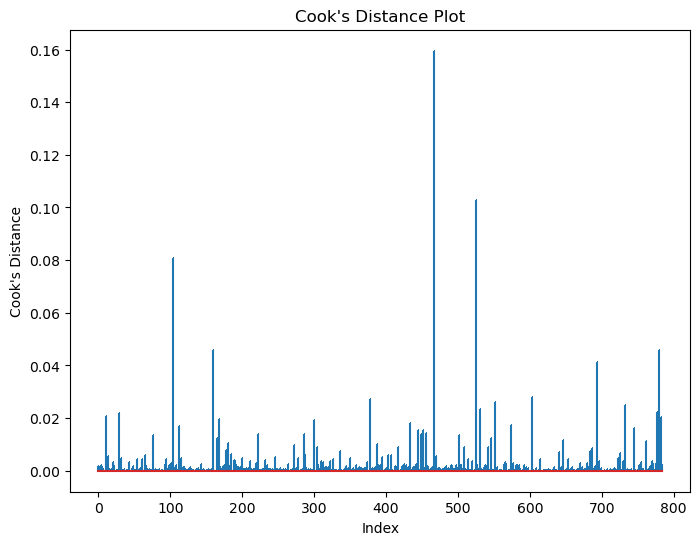

In [21]:
results = create_model(X, y)

- residuals still have some skew
- after dropping variables, residuals show some banding. Some is to be expected with a log transformation. 
- overall residuals are normally distributed, indicating the model is an ok fit.
- the model explains a significant portion of the variance in both the training and testing datasets. It is generally good but could potentially be improved.  
- no points were overly influential

# back-transforming & interpreting results


In [22]:
# Exp reverses our log transformation 
coef = np.exp(results.params)
conf_int = np.exp(results.conf_int())


print("Coefficients:")
print(coef)
print("\nConfidence Intervals:")
print(conf_int)


Coefficients:
const                   14.304043
units                    1.488319
category_Electronics     1.685112
age_category_25-34       0.888532
month_11                 1.525147
month_12                 1.503043
units_squared            0.990699
dtype: float64

Confidence Intervals:
                              0          1
const                 12.643378  16.182831
units                  1.436477   1.542032
category_Electronics   1.534911   1.850011
age_category_25-34     0.796531   0.991159
month_11               1.276888   1.821674
month_12               1.250299   1.806878
units_squared          0.988576   0.992827


This model explains 69.7% of the variability in sales. 
We can see there is a positive relationship between sales & units, the electronic category. There is also suggestion of a negative relationship to people aged 25 - 34. 
This model does not suggest there is a relationship between sales & gender. It does suggest seasonality has an effect on the data.


- For every one-unit increase in units sold, we expect sales to increase by approximately 148.83% (after other variables accounted for).


- Sales of electronic items are expected to be approximately 68.51% higher than other categories.

- Sales are expected to be approximately 11.34% lower among individuals aged 25-34 compared to other age categories.
    - Based on my real-life knowledge - that this age group is made up of young professionals who generally have money and the tech-savvy nature of this age group, I doubt this. Especially as originally looking at the variable, it seemed randomly distributed.
    - Perhaps there are many young parents, and less likely to spend?
    - I included this age group despite p-value being slightly above 0.05 threshold, it likely should be removed.  



- In November, sales are expected to increase by approximately 52.52%, and in December, sales are expected to increase by approximately 50.30% compared to other months.
    - Indicates people are sales-driven (Black Friday) or driven to buy for other people (Christmas). 
    - There must be a factor explaining some of the data for December, as I would expect December to be higher than November here. 


- For every one-unit increase in the square of units sold, there's an approximately 32.36% increase in sales.
    - Aka: For every time you double the number of units sold, the increase in sales is about 32.36%. 
    - Diminishing returns: while selling more units is great for sales, there comes a point where each additional unit sold doesn't have as big of an impact on increasing sales as it did before (increasing at a decreasing rate).
    - I imagine this is because in very large orders customers are more likely to choose cheaper items. 


#### What I would do going forward:

- check interation plots. Particularly to see if this explains more for December & gender e.g. genderFemale x Beauty.
- forecast with a time-series analysis
- feedback loop to improve model
- cross validation  

## appendix
useful for presenting

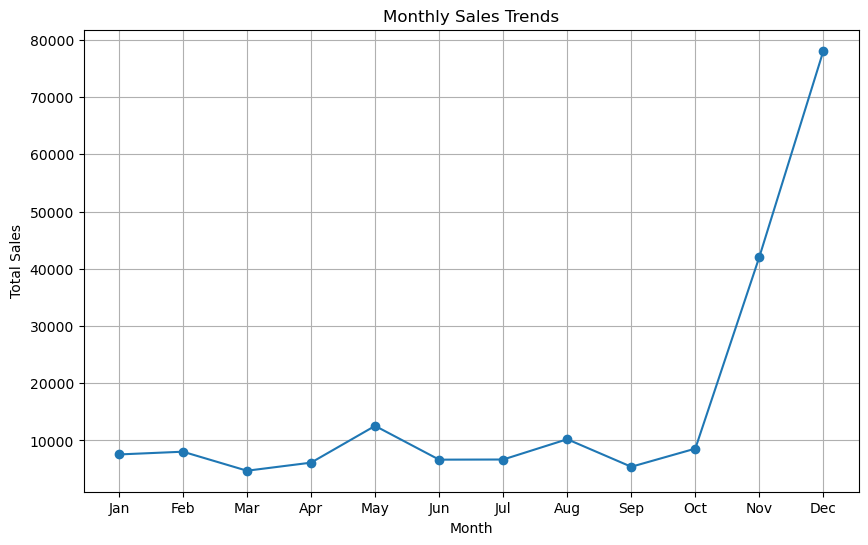

In [23]:
df['month'] = df['date'].dt.month

# Group by month and calculate total sales
monthly_sales = df.groupby('month')['sales'].sum()

plt.figure(figsize=(10, 6))
monthly_sales.plot(marker='o')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()
